<center><h1 style:"text-align:center;">Formulación 1</h1></center>
<center><h3>Base Notebook</h3></center>

### 1. Imports

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Acceder al sistema operativo
import os
import glob
import shutil
import random



c:\Users\aherrada\Documents\Git\Pytorch\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Model Parameters

#### LSTM parameters

- **n_signals:** number of signals fed into model for each event.
    - For example: for input signals: [$I_{a}$, $I_{b}$, $I_{c}$] -> n_signals = 3).
    <br><br>
- **N:** window size. 
    - For 3840Hz sampling frequency and a 0.016ms window (containing one cycle of a 60Hz wave), N = 64.
    \begin{equation}
    N = \frac{fs}{f_{fundamental}} w
    \end{equation}
    <br>
- **hidden_dim:** The number of features in the hidden state $a^{\langle t \rangle}$ (also refered as $h^{\langle t \rangle}$)

    
    
    
    



- **train/test/dev_batch_size**: mini-batch size.
    - train: portion of dataset used to train the model (i.e. adjust the weigths and biases).
    - test: portion of dataset used to estimate the performance of the model.
    <br><br>
    

<figure> 
<center><img src="./images/DatabaseSchema.jpeg" style="height:220px;width:330px;"></center>
<caption><center><font color='whitesmoke'><b>Figure 1.</b> Mini-batch dataset geometry </font></center></caption>
</figure>


- **target_size:** number of classes.
    - target_size = 1:
        - Binary Classification: One output treated as probability of belonging to one class or the other (E.g. No-Fault = 0 | Fault = 1)
    - target_size > 1:
        - Multiclass: Multiple exclusive classes. Class with higher score represents predicted class. The sum of scores (using softmax) adds up 1.<br> (E.g. [No-fault, Fault, Caps], an output of values [0.07, 0.91, 0.2] represents a Fault class prediction)
        - Multilabel: Multiple classes that are not mutually exclusive. Each position of output vector is a probability (using sigmoid).
<br> (E.g. [$\phi_A$, $\phi_B$, $\phi_C$], an output of values [0.95, 0.90, 0.01 ] represents faulted phases *A* and *B*, i.e. biphasic *AB* fault )






In [3]:
# LSTM parameters
hidden_dim = 20
n_signals = 1
N = 64

# _batch_size => m in figure 1.
train_batch_size = 64
dev_batch_size = 16
test_batch_size = 16

# Classification type (binary)
tagset_size = 1

# Set
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cpu


### 3. Model Creation

The fault detector model consists of a block of *N* LSTM cells (figure 2.) in series. This block processes one training sample at a time (moving window). For each moving window, each cell processes a sample of the signal, and will pass context information sequentially to the next cell. This information will be passed in the hidden state $a^{\langle t \rangle}$  and the cell state $c^{\langle t \rangle}$. 


Each LSTM's input $x^{\langle t \rangle}$ is combined with it's previous hidden state $a^{\langle t - 1 \rangle}$. 
Each LSTM's cell state $c^{\langle t \rangle}$. will be inputed to the next LSTM $_{t + 1}$ . At each step $c^{\langle t \rangle}$ is updated to add _(remember)_ or delete _(forget)_ information.

At each time step, $a^{\langle t \rangle}$ can be passed through a sigmoid function to obatain an output $\hat{y}^{\langle t \rangle}$. However, this yields a many-to-many model. Since fault detection is made after processing _N_ input samples inside a moving window, only one label is needed per window (no-fault/fault) making it possible to approach the problem as binary classification. 
In other words, for each moving window, the prediction will be made at the last LSTM block cell, i.e. $\hat{y}^{\langle N-1 \rangle}$.

<br>


<figure> 
<center><img src="./images/LSTM_cell.png" style="width:500;height:400px;" ></center>
<caption><center><b>Figure 2.</b>LSTM cell</center></caption>
</figure>


##### WRITE MORE LSTM INFORMATION

The LSTM block will be fed an input vector of dimension (m, N, s), where:

            - m: mini-batch size.
            - N: moving window size.
            - s: signals _(n_signals)_
        
Pytorch **nn.Module** class will be used to create the FaultDetector LSTM detector class following the architecture shown in figure 3. The FaultDetector class includes the LSTM, linear and sigmoid blocks shown in the flow diagram. The linear + sigmoid blocks work as the classifier part of the model. The hidden activation $a^{\langle N-1 \rangle}$ _(lstm_out[:, -1, :])_ is passed through the classifier block to obtain $\hat{y}^{\langle N-1 \rangle}$, with dimensions (m, 1).


<figure> 
<center><img src="./images/LSTM_binary.jpeg" style="width:700;height:600px;"></center>
<caption><center><b>Figure 3.</b>LSTM detector flow diagram</center></caption>
</figure>


##### 3.1. FaultDetector Class Creation

In [4]:
# Model Creation


class FaultDetector(nn.Module):
    """Some Information about FaultDetector"""

    def __init__(self, N, hidden_dim, tagset_size):
        super(FaultDetector, self).__init__()
        self.lstm = nn.LSTM(N, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        fc_layer = self.fc(lstm_out[:, -1, :])

        return torch.sigmoid(fc_layer)




##### 3.2. Model Instance Initialization

In [5]:
model = FaultDetector(n_signals, hidden_dim, tagset_size).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# Learning rate decay (optional)

decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer, gamma=decayRate
)

# Model Summary
print(f"Model structure: {model}\n")

# Number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters: {params}")

Model structure: FaultDetector(
  (lstm): LSTM(1, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

1861


### 4. Dataset Creation

##### 4.1. Dataset Class Creation

In [6]:
from utils.signalload import CSV_pandas_path
from utils.auxfunctions import moving_window
import numpy as np
from itertools import repeat


class Form1Dataset(torch.utils.data.Dataset):
    """Some Information about Form1Dataset"""

    def __init__(
        self,
        dataset_dir,
        signal_name,
        max_window_idx=193,
        window_length=64,
        step=1,
        test=False,
    ):
        super(Form1Dataset, self).__init__()
        self.max_window_idx = max_window_idx
        self.test = test
        self.signal_name = signal_name

        self.csv_list = glob.glob(f"{dataset_dir}*.csv")
        self.csv_amount = len(self.csv_list)
        self.windows_amount = max_window_idx * self.csv_amount
        self.window_length = window_length
        self.step = step

    def __getitem__(self, index):

        # sample_settings
        window_length = self.window_length
        step = self.step

        # Calculate window_idx and file name
        window_idx = index % self.max_window_idx
        csv_idx = index // self.max_window_idx
        csv_full_path = self.csv_list[csv_idx]

        # Load CSV, signal and create windows
        csv_name = os.path.basename(csv_full_path)
        signal, t, _ = CSV_pandas_path(csv_full_path).load_data(self.signal_name)
        signal_windows, t_windows = list(
            map(moving_window, [signal, t], repeat(window_length), repeat(step))
        )

        # select window

        signal_window = signal_windows[window_idx]
        signal_window = np.expand_dims(signal_window, axis=1)
        t_window = t_windows[window_idx]

        # create labels
        if window_idx < 66:
            label = np.array([0])
        else:
            label = np.array([1])

        # For dataset visualization return following information
        signal_window = torch.from_numpy(np.copy(signal_window)).float()
        label = torch.from_numpy(label).float()
        if self.test == True:
            return signal_window, t_window, label, csv_name, index, window_idx

        # For training only signals and labels are required
        
        return signal_window, label

    def __len__(self):
        return self.csv_amount * self.max_window_idx

##### 4.2. Database Directory Creation

In [7]:
# Creating Dataset Folders

dataset_dir_full = "C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1/fault_01/"
dataset_dir = "C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1/R1/"
dataset_dir_R2 = "C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1/R2/"
dataset_dir_R3 = "C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1/R3/"
max_window_idx = 130
n_events = 35


def dataset_creator(source_path, target_path, signal_list=False):
    csv_list = glob.glob(f"{source_path}*.csv")
    if not os.path.isdir(target_path):
        print("creating")
        os.makedirs(target_path)
    else:
        file_list = glob.glob(f"{target_path}*.csv")
        for file in file_list:
            os.remove(file)
    csv_list = random.sample(csv_list, n_events)
    print(f"copying {len(csv_list)} files...")
    for csv in csv_list:
        source_path = csv
        target_path = target_path
        shutil.copy(source_path, target_path)
    print("finished")
    print("Available Relays (current):")
    if signal_list == True:
        CSV_pandas_path(csv_list[0]).relay_list()


# Crear los 3 Datasets para entrenar los relés individualmente
dataset_creator(dataset_dir_full, dataset_dir, signal_list=True)
dataset_creator(dataset_dir_full, dataset_dir_R2)
dataset_creator(dataset_dir_full, dataset_dir_R3)


copying 35 files...
finished
Available Relays (current):
I: X0038A-X0043A
I: X0038B-X0043B
I: X0038C-X0043C
I: X0048A-X0053A
I: X0048B-X0053B
I: X0048C-X0053C
I: X0060A-X0065A
I: X0060B-X0065B
I: X0060C-X0065C
I: X0066A-X0067A
I: X0066B-X0067B
I: X0066C-X0067C
I: X0023A-R1A
I: X0023B-R1B
I: X0023C-R1C
I: X0004A-R2A
I: X0004B-R2B
I: X0004C-R2C
I: X0071A-R3A
I: X0071B-R3B
I: X0071C-R3C
copying 35 files...
finished
Available Relays (current):
copying 35 files...
finished
Available Relays (current):


##### 4.3. Dataset and Dataloader Instances Creation

In [8]:
# Load Dataset
signal_name = "I: X0023A-R1A"
dataset = Form1Dataset(
    dataset_dir, max_window_idx=max_window_idx, signal_name=signal_name
)
train_dataset, test_dataset = random_split(dataset, [0.95, 0.05])
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
# EL test set realmente es un dev set
# Como regla general, si es utilizado dentro del loop es un dev set.

### 5. Model Training

##### 5.1. Train / Test(dev) Loop Creation

In [9]:
# Create Training / Test / Validation Loops

# Training
def train(dataloader, model, loss_fn, optimizer, return_loss = False):
    size = len(dataloader.dataset)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if return_loss == True:
            loss_list.append(loss.item())
        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>f} [{current:>5d}/{size:>5d}]")

        if batch % 5 == 0:
            my_lr_scheduler.step()
    if return_loss == True:
        return loss_list



def test(dataloader, model, loss_fn, return_metrics=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )
    if return_metrics==True:
        return correct*100, test_loss


##### 5.2. Training the Model

In [11]:
epochs = 1
for epoch in range(epochs):
    
    print(f"Epoch {epoch+1}\n--------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer, return_loss=True)
    test(test_dataloader, model, loss_fn)

Epoch 1
--------------------------------
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.103665 



##### 5.3. Loss Visualization

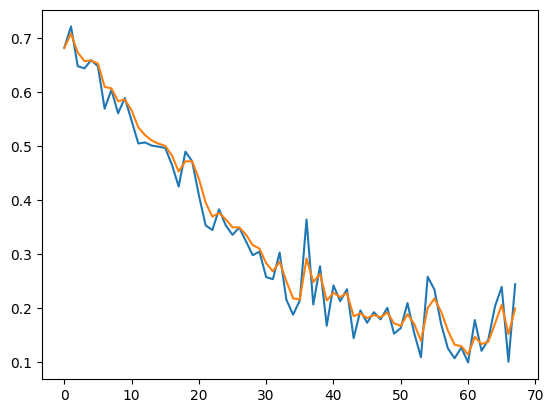

In [10]:
mini_batch_list = [index for index, _ in enumerate(train_loss)]
train_loss_ewm = pd.DataFrame(train_loss).ewm(com=0.95).mean()
plt.plot(mini_batch_list, train_loss, mini_batch_list, train_loss_ewm)


##### 5.4. Saving the Model

In [11]:
# # Save the Model
# torch.save(model.state_dict(), './models/LSTMHarmonic_weights_R1_996.pth')
# model.load_state_dict(torch.load('./models/LSTMHarmonic_weights_989.pth'))


### 6. Results Visualization

#### 6.1. Confussion Matrix Results Table Function

In [12]:
# Data visualization (CPU)

def confussion_matrix_labels(pred_label, true_label):
    label = ""
    if int(pred_label) == int(true_label):
        label += "True"
    else:
        label += "False"
    if pred_label == 1:
        label += " positive"
    else:
        label += " negative"
    return label


def confussion_matrix(x, labels):
    data = {
        "Pred probability": torch.reshape(x, (-1,)).numpy(),
        "Pred label": torch.reshape(torch.round(x), (-1,)).int().numpy(),
        "True label": torch.reshape(labels, (-1,)).int().numpy(),
    }
    df = pd.DataFrame(data)
    df["prueba"] = confussion_matrix_pandas(df["Pred label"], df["True label"])
    return df

confussion_matrix_pandas = np.vectorize(confussion_matrix_labels)


##### 6.2. Matlab Plots

   Pred probability  Pred label  True label         prueba
0          0.970602           1           1  True positive
1          0.888951           1           1  True positive
2          0.978314           1           1  True positive
3          0.030253           0           0  True negative
4          0.149297           0           0  True negative
5          0.977493           1           1  True positive
6          0.870592           1           1  True positive
7          0.025624           0           0  True negative
8          0.887179           1           1  True positive


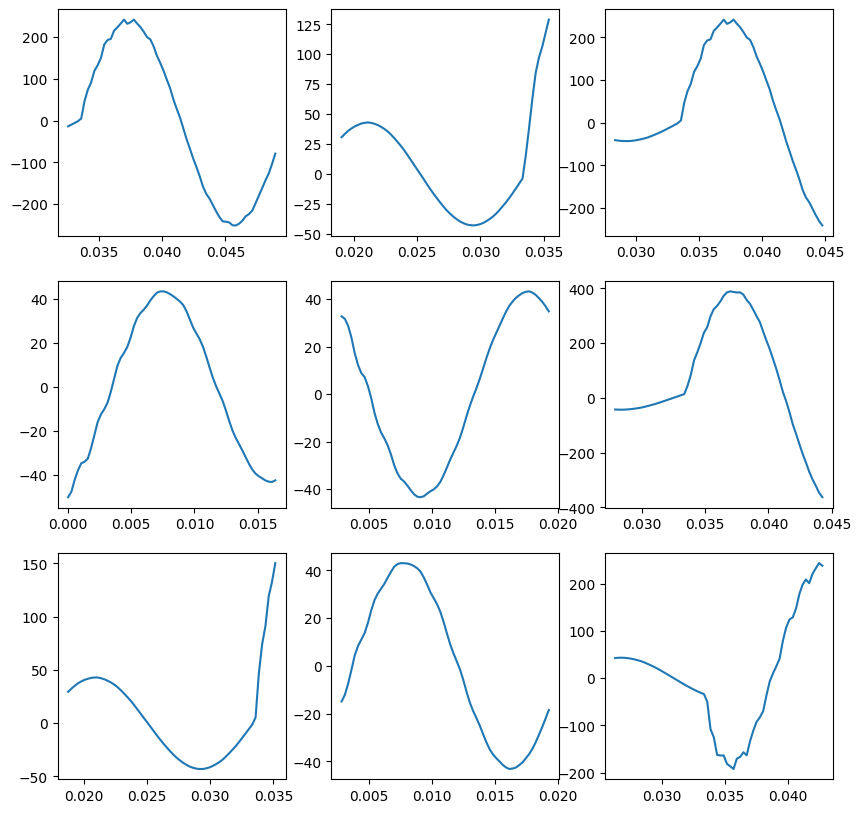

In [13]:
dataset_test = Form1Dataset(
    dataset_dir, max_window_idx=max_window_idx, signal_name=signal_name, test=True
)
test_dataloader = DataLoader(dataset_test, batch_size=train_batch_size, shuffle=True)

dataiter = iter(test_dataloader)
signal_windows, t_windows, labels, *_ = next(dataiter)
fs = 3840

x = model(signal_windows[1:10].to(device))
x = x.detach()

# Crear Matriz de confusión
df = confussion_matrix(x, labels[1:10])
print(df)

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t_windows[i, :], signal_windows[i, :, 0])


##### 6.3. Plotly Plot

In [14]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fs = 3840
dataset_test = Form1Dataset(
    dataset_dir, max_window_idx=max_window_idx, signal_name=signal_name, test=True
)
train_dataloader = DataLoader(dataset_test, batch_size=train_batch_size, shuffle=True)

dataiter = iter(train_dataloader)
signal_windows, t_windows, labels, *_ = next(dataiter)

x = model(signal_windows[1:10].to(device))
x = x.detach()

# Crear Matriz de confusión
df = confussion_matrix(x, labels[1:10])
print(df)

# figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
fig = make_subplots(rows=rows, cols=cols)

for i in range(0, cols * rows):

    col = i % cols
    row = i // cols
    fig.add_trace(
        go.Scatter(
            name=i, x=t_windows[i, :], y=signal_windows[i, :, 0], marker_color="black"
        ),
        row=row + 1,
        col=col + 1,
    )

fig.update_layout(
    height=700,
    width=900,
    title_text="Figuras",
    margin={"b": 20, "t": 40, "l": 20, "r": 30},
    plot_bgcolor="rgba(0,0,0,0)",
    # paper_bgcolor="whitesmoke",
)
fig.show()


   Pred probability  Pred label  True label         prueba
0          0.154364           0           0  True negative
1          0.043757           0           0  True negative
2          0.977443           1           1  True positive
3          0.093179           0           0  True negative
4          0.889391           1           1  True positive
5          0.027588           0           0  True negative
6          0.884128           1           1  True positive
7          0.028989           0           0  True negative
8          0.030503           0           0  True negative


## Modelo R2 

In [15]:
# Load Dataset
signal_name_R2 = "I: X0004A-R2A"
dataset_R2 = Form1Dataset(
    dataset_dir_R2, max_window_idx=max_window_idx, signal_name=signal_name_R2
)
train_dataset, test_dataset, dev_dataset = random_split(dataset_R2, [0.9, 0.09, 0.01])
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
# EL test set realmente es un dev set
# Como regla general, si es utilizado dentro del loop es un dev set.
dev_dataloader = DataLoader(dev_dataset, batch_size=dev_batch_size, shuffle=True)
epochs = 1

# Create Model

model_R2 = FaultDetector(n_signals, hidden_dim, tagset_size).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_R2.parameters(), lr=1e-2)
# Learning rate decay
decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

print(f"Model structure: {model_R2}\n")


for epoch in range(epochs):
    
    print(f"Epoch {epoch+1}\n--------------------------------")
    train_loss = train(train_dataloader, model_R2, loss_fn, optimizer, return_loss=True)
    test(test_dataloader, model_R2, loss_fn)


Model structure: FaultDetector(
  (lstm): LSTM(1, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

Epoch 1
--------------------------------
loss: 0.699276 [    0/ 4096]
loss: 0.640427 [  128/ 4096]
loss: 0.623498 [  256/ 4096]
loss: 0.601174 [  384/ 4096]
loss: 0.574079 [  512/ 4096]
loss: 0.513729 [  640/ 4096]
loss: 0.487733 [  768/ 4096]
loss: 0.436654 [  896/ 4096]
loss: 0.429537 [ 1024/ 4096]
loss: 0.396921 [ 1152/ 4096]
loss: 0.314566 [ 1280/ 4096]
loss: 0.296397 [ 1408/ 4096]
loss: 0.255865 [ 1536/ 4096]
loss: 0.307133 [ 1664/ 4096]
loss: 0.269831 [ 1792/ 4096]
loss: 0.185034 [ 1920/ 4096]
loss: 0.232722 [ 2048/ 4096]
loss: 0.238132 [ 2176/ 4096]
loss: 0.142724 [ 2304/ 4096]
loss: 0.171021 [ 2432/ 4096]
loss: 0.277281 [ 2560/ 4096]
loss: 0.168091 [ 2688/ 4096]
loss: 0.189481 [ 2816/ 4096]
loss: 0.121623 [ 2944/ 4096]
loss: 0.151956 [ 3072/ 4096]
loss: 0.083514 [ 3200/ 4096]
loss: 0.090595 [ 3328/ 4096]
loss: 0.132138 [ 3456/ 4096]
loss: 0.148001

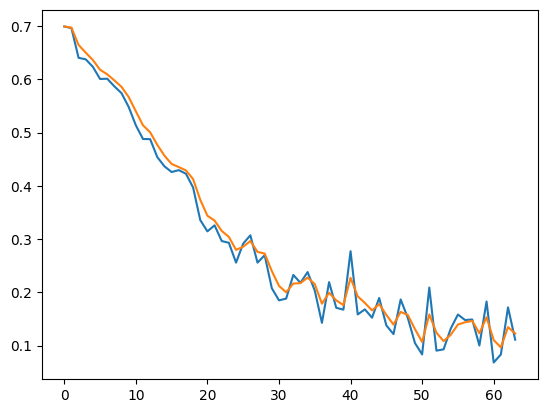

In [16]:
mini_batch_list = [index for index, _ in enumerate(train_loss)]
train_loss_ewm = pd.DataFrame(train_loss).ewm(com=0.98).mean()
plt.plot(mini_batch_list, train_loss, mini_batch_list, train_loss_ewm)

In [17]:
# # Save the Model_R2
# torch.save(model_R2.state_dict(), './models/LSTMHarmonic_weights_R2_972.pth')
# model_R2.load_state_dict(torch.load('./models/LSTMHarmonic_weights_989.pth'))

torch.Size([16, 64, 1])
tensor([[0., 0., 1., 1., 0., 0., 1., 0., 1.]])
tensor([[0., 0., 0., 1., 0., 0., 1., 0., 1.]], grad_fn=<ReshapeAliasBackward0>)
tensor([[0.0243, 0.0284, 0.0497, 0.9431, 0.0319, 0.0409, 0.9745, 0.0578, 0.9702]],
       grad_fn=<ReshapeAliasBackward0>)


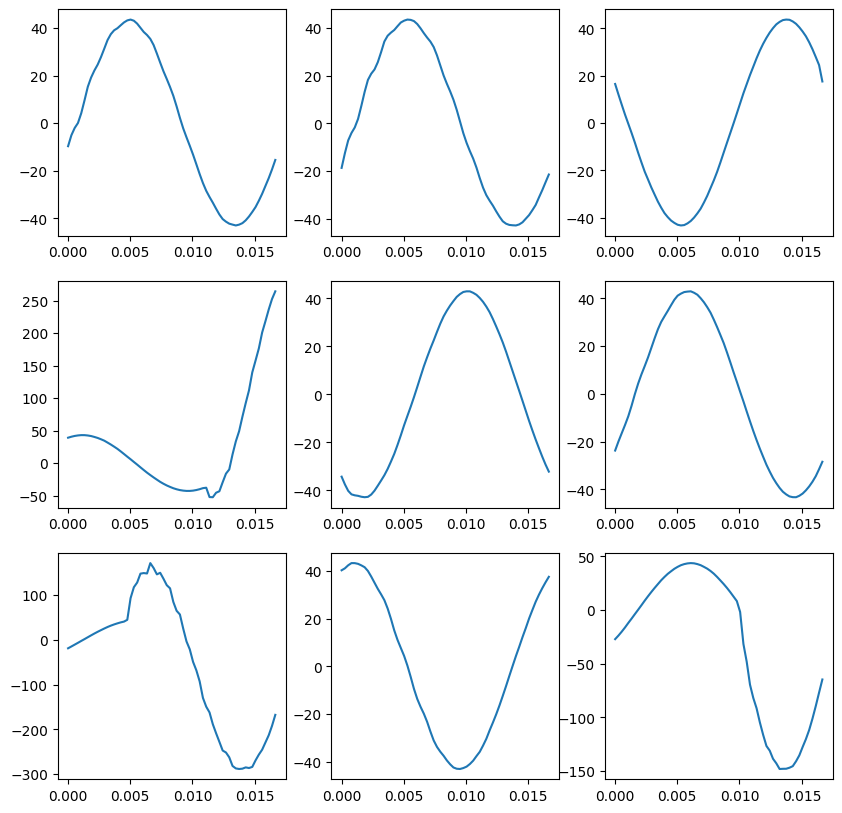

In [18]:
dataiter = iter(dev_dataloader)
signal, labels = next(dataiter)
fs = 3840
t = np.linspace(0, N / fs, N)
print(signal.shape)
print(torch.reshape(labels[1:10], (1, -1)))
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t, signal[i, :, 0])
x = model_R2(signal[1:10].to(device))
print(torch.reshape(torch.round(x), (1, -1)))
print(torch.reshape(x, (1, -1)))

## Modelo R3

In [19]:
# Load Dataset
signal_name_R3 = "I: X0071A-R3A"
dataset_R3 = Form1Dataset(
    dataset_dir_R3, max_window_idx=max_window_idx, signal_name=signal_name_R3
)
train_dataset, test_dataset, dev_dataset = random_split(dataset_R3, [0.9, 0.09, 0.01])
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
# EL test set realmente es un dev set
# Como regla general, si es utilizado dentro del loop es un dev set.
dev_dataloader = DataLoader(dev_dataset, batch_size=dev_batch_size, shuffle=True)
epochs = 1

# Create Model

model_R3 = FaultDetector(n_signals, hidden_dim, tagset_size).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_R3.parameters(), lr=1e-2)
# Learning rate decay
decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

print(f"Model structure: {model_R3}\n")


for epoch in range(epochs):
    
    print(f"Epoch {epoch+1}\n--------------------------------")
    train_loss = train(train_dataloader, model_R3, loss_fn, optimizer, return_loss=True)
    test(test_dataloader, model_R3, loss_fn)

Model structure: FaultDetector(
  (lstm): LSTM(1, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

Epoch 1
--------------------------------
loss: 0.688448 [    0/ 4096]
loss: 0.619775 [  128/ 4096]
loss: 0.582305 [  256/ 4096]
loss: 0.558069 [  384/ 4096]
loss: 0.532146 [  512/ 4096]
loss: 0.510895 [  640/ 4096]
loss: 0.475235 [  768/ 4096]
loss: 0.408887 [  896/ 4096]
loss: 0.462808 [ 1024/ 4096]
loss: 0.363916 [ 1152/ 4096]
loss: 0.348708 [ 1280/ 4096]
loss: 0.325589 [ 1408/ 4096]
loss: 0.322745 [ 1536/ 4096]
loss: 0.288809 [ 1664/ 4096]
loss: 0.297721 [ 1792/ 4096]
loss: 0.404995 [ 1920/ 4096]
loss: 0.323360 [ 2048/ 4096]
loss: 0.267944 [ 2176/ 4096]
loss: 0.289457 [ 2304/ 4096]
loss: 0.257210 [ 2432/ 4096]
loss: 0.205581 [ 2560/ 4096]
loss: 0.326841 [ 2688/ 4096]
loss: 0.240391 [ 2816/ 4096]
loss: 0.196868 [ 2944/ 4096]
loss: 0.197302 [ 3072/ 4096]
loss: 0.202544 [ 3200/ 4096]
loss: 0.153139 [ 3328/ 4096]
loss: 0.213567 [ 3456/ 4096]


KeyboardInterrupt: 

0.1790877729654312

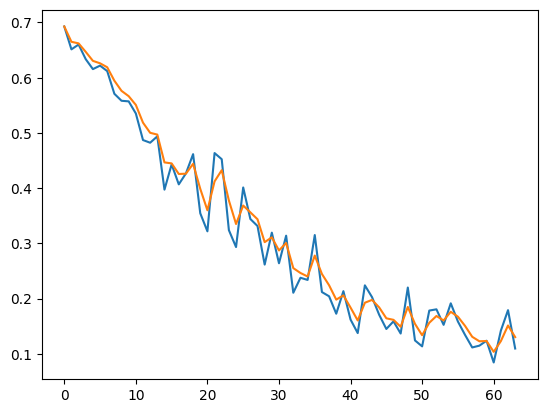

In [ ]:
mini_batch_list = [index for index, _ in enumerate(train_loss)]
train_loss_ewm = pd.DataFrame(train_loss).ewm(com=0.98).mean()
plt.plot(mini_batch_list, train_loss, mini_batch_list, train_loss_ewm)
train_loss[-2]

In [70]:
# # Save the Model_R2
# torch.save(model_R3.state_dict(), './models/LSTMHarmonic_weights_R3_983.pth')
# model_R2.load_state_dict(torch.load('./models/LSTMHarmonic_weights_989.pth'))

torch.Size([16, 64, 1])
tensor([[1., 1., 0., 1., 1., 0., 1., 0., 1.]])
tensor([[1., 1., 0., 1., 1., 0., 1., 0., 1.]], grad_fn=<ReshapeAliasBackward0>)
tensor([[0.9562, 0.9559, 0.0382, 0.9664, 0.9712, 0.0191, 0.9659, 0.0283, 0.9659]],
       grad_fn=<ReshapeAliasBackward0>)


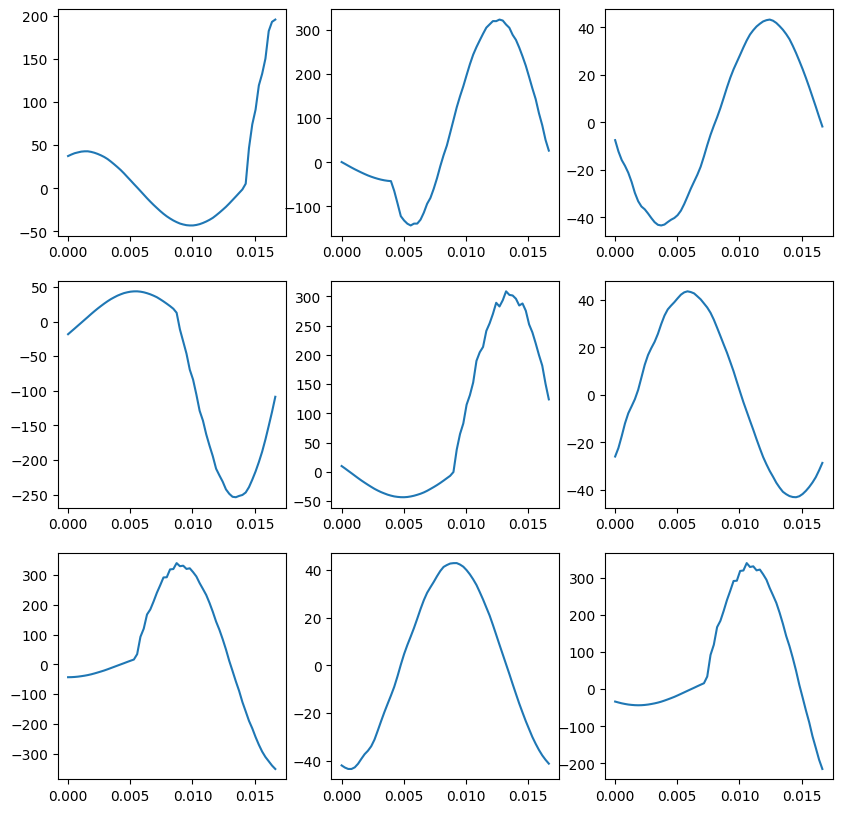

In [74]:
dataiter = iter(dev_dataloader)
signal, labels = next(dataiter)
fs = 3840
t = np.linspace(0, N / fs, N)
print(signal.shape)
print(torch.reshape(labels[1:10], (1, -1)))
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t, signal[i, :, 0])
x = model_R2(signal[1:10].to(device))
print(torch.reshape(torch.round(x), (1, -1)))
print(torch.reshape(x, (1, -1)))

### 7. References
1. PyTorch Contributors: LSTM. [LSTM — PyTorch 1.13 documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
<!-- @online{LSTM,
    author = "{PyTorch Contributors}",
    title = "LSTM",
    url  = "https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html",
    addendum = "(accessed: 10.02.2023)",
    keywords = "LSTM pytorch"
} -->

